In [1]:
import argparse, os
import torch
import numpy as np
from omegaconf import OmegaConf
from PIL import Image
from tqdm import trange, tqdm
from einops import rearrange
from pytorch_lightning import seed_everything
from torch import autocast
from contextlib import nullcontext
import json
from pnp_utils import check_safety

from pnp_ldm.util import instantiate_from_config
from pnp_ldm.models.diffusion.ddim import DDIMSampler
from run_features_extraction import load_model_from_config
import torch.nn.functional as F

2023-05-07 18:06:50.603432: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-07 18:06:51.427439: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:
2023-05-07 18:06:51.427551: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:
2023-05-07 18:06:51.427558: W tensorflow/compiler/tf2tensorrt/utils/py_utils

In [2]:
class Args:
    def __init__(self):
        self.config = '/hdd/junyi/plug-and-play/configs/pnp/pnp-generated_swap.yaml'
        self.ddim_eta = 0.0
        self.H = 512
        self.W = 512
        self.C = 4
        self.f = 8
        self.model_config = 'configs/stable-diffusion/v1-inference.yaml'
        self.ckpt = 'models/ldm/stable-diffusion-v1/model.ckpt'
        self.precision = 'autocast'
        self.check_safety = False

opt = Args()

exp_config = OmegaConf.load(opt.config)

In [3]:
model_config = OmegaConf.load(f"{opt.model_config}")
model = load_model_from_config(model_config, f"{opt.ckpt}")

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)
sampler = DDIMSampler(model)

Loading model from models/ldm/stable-diffusion-v1/model.ckpt
Global Step: 840000
LatentDiffusion: Running in eps-prediction mode


/home/ubuntu/anaconda3/envs/colossal/lib/python3.10/site-packages/pytorch_lightning/utilities/distributed.py:258: LightningDeprecationWarning: `pytorch_lightning.utilities.distributed.rank_zero_only` has been deprecated in v1.8.1 and will be removed in v2.0.0. You can import it from `pytorch_lightning.utilities` instead.
  rank_zero_deprecation(


DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.3.self_attn.out_proj.bias', 'vision_model.encoder.layers.14.layer_norm2.weight', 'vision_model.encoder.layers.11.layer_norm2.weight', 'vision_model.encoder.layers.10.layer_norm1.weight', 'vision_model.encoder.layers.16.layer_norm2.bias', 'vision_model.encoder.layers.12.self_attn.q_proj.bias', 'vision_model.encoder.layers.18.mlp.fc1.bias', 'vision_model.encoder.layers.14.layer_norm1.weight', 'vision_model.encoder.layers.18.layer_norm2.weight', 'vision_model.encoder.layers.1.self_attn.k_proj.bias', 'vision_model.encoder.layers.3.mlp.fc2.weight', 'vision_model.encoder.layers.3.layer_norm2.weight', 'vision_model.encoder.layers.23.mlp.fc1.bias', 'vision_model.encoder.layers.3.self_attn.v_proj.bias', 'vision_model.encoder.layers.9.self_attn.k_proj.bias', 'vision_model.encoder.layers.7.self_attn.out_proj.weight', 'vision_model.encoder.layers.2.self

In [5]:
exp_path_root_config = OmegaConf.load("./configs/pnp/setup.yaml")
exp_path_root = exp_path_root_config.config.exp_path_root

# read seed from args.json of source experiment
with open(os.path.join(exp_path_root, exp_config.source_experiment_name, "args.json"), "r") as f:
    args = json.load(f)
    seed = args["seed"]
    # source_prompt = args["prompt"]
with open(os.path.join(exp_path_root, exp_config.target_experiment_name, "args.json"), "r") as f:
    args2 = json.load(f)
    # seed = args["seed"]
    target_prompt = args2["prompt"]

seed = torch.initial_seed()
opt.seed = seed
seed_everything(seed)
possible_ddim_steps = args["save_feature_timesteps"]
assert exp_config.num_ddim_sampling_steps in possible_ddim_steps or exp_config.num_ddim_sampling_steps is None, f"possible sampling steps for this experiment are: {possible_ddim_steps}; for {exp_config.num_ddim_sampling_steps} steps, run 'run_features_extraction.py' with save_feature_timesteps = {exp_config.num_ddim_sampling_steps}"
ddim_steps = exp_config.num_ddim_sampling_steps if exp_config.num_ddim_sampling_steps is not None else possible_ddim_steps[-1]

negative_prompt = target_prompt if exp_config.negative_prompt is None else exp_config.negative_prompt
sampler.make_schedule(ddim_num_steps=ddim_steps, ddim_eta=opt.ddim_eta, verbose=False) 


translation_folders = [p.replace(' ', '_') for p in exp_config.prompts]
outpaths = [os.path.join(f"{exp_path_root}/{exp_config.source_experiment_name}/translations", f"{exp_config.scale}_{translation_folder}") for translation_folder in translation_folders]
out_label = f"INJECTION_T_{exp_config.feature_injection_threshold}_STEPS_{ddim_steps}"
out_label += f"_NP-ALPHA_{exp_config.negative_prompt_alpha}_SCHEDULE_{exp_config.negative_prompt_schedule}_NP_{negative_prompt.replace(' ', '_')}"

predicted_samples_paths = [os.path.join(outpath, f"predicted_samples_{out_label}") for outpath in outpaths]


batch_size = len(exp_config.prompts)
prompts = exp_config.prompts
assert prompts is not None

Global seed set to 877203136


In [6]:
for i in range(len(outpaths)):
    os.makedirs(outpaths[i], exist_ok=True)
    os.makedirs(predicted_samples_paths[i], exist_ok=True)
    # save args in experiment dir
    with open(os.path.join(outpaths[i], "args.json"), "w") as f:
        json.dump(OmegaConf.to_container(exp_config), f)

def save_sampled_img(x, i, save_paths):
    for im in range(x.shape[0]):
        x_samples_ddim = model.decode_first_stage(x[im].unsqueeze(0))
        x_samples_ddim = torch.clamp((x_samples_ddim + 1.0) / 2.0, min=0.0, max=1.0)
        x_samples_ddim = x_samples_ddim.cpu().permute(0, 2, 3, 1).numpy()
        x_image_torch = torch.from_numpy(x_samples_ddim).permute(0, 3, 1, 2)
        x_sample = x_image_torch[0]

        x_sample = 255. * rearrange(x_sample.cpu().numpy(), 'c h w -> h w c')
        img = Image.fromarray(x_sample.astype(np.uint8))
        img.save(os.path.join(save_paths[im], f"{i}.png"))

def ddim_sampler_callback(pred_x0, xt, i):
    save_sampled_img(pred_x0, i, predicted_samples_paths)

In [7]:
src_feature=torch.load(os.path.join(exp_path_root, exp_config.source_experiment_name,"fused_feature.pt")).cuda() # (1,1,3600,768*2)
tgt_feature=torch.load(os.path.join(exp_path_root, exp_config.target_experiment_name,"fused_feature.pt")).cuda() # (1,1,3600,768*2)
src_mask=torch.load(os.path.join(exp_path_root, exp_config.source_experiment_name,"mask.pt")).cuda() # mask1 shape (840,840)
tgt_mask=torch.load(os.path.join(exp_path_root, exp_config.target_experiment_name,"mask.pt")).cuda() # mask2 shape (840,840)
src_feature_reshaped = src_feature.squeeze().permute(1,0).reshape(1,-1,60,60)
tgt_feature_reshaped = tgt_feature.squeeze().permute(1,0).reshape(1,-1,60,60)

In [8]:
def load_target_features():
    self_attn_output_block_indices = []
    out_layers_output_block_indices = [4]
    output_block_self_attn_map_injection_thresholds = [ddim_steps // 2] * len(self_attn_output_block_indices)
    feature_injection_thresholds = [exp_config.feature_injection_threshold]
    target_features = []

    source_experiment_out_layers_path = os.path.join(exp_path_root, exp_config.source_experiment_name, "feature_maps")
    source_experiment_qkv_path = os.path.join(exp_path_root, exp_config.source_experiment_name, "feature_maps")

    target_experiment_out_layers_path = os.path.join(exp_path_root, exp_config.target_experiment_name, "feature_maps")
    target_experiment_qkv_path = os.path.join(exp_path_root, exp_config.target_experiment_name, "feature_maps")

    time_range = np.flip(sampler.ddim_timesteps)
    total_steps = sampler.ddim_timesteps.shape[0]

    iterator = tqdm(time_range, desc="loading source experiment features", total=total_steps)
    

    for i, t in enumerate(iterator):
        current_features = {}
        for (output_block_idx, output_block_self_attn_map_injection_threshold) in zip(self_attn_output_block_indices, output_block_self_attn_map_injection_thresholds):
            if i <= int(output_block_self_attn_map_injection_threshold):
                output_q = torch.load(os.path.join(source_experiment_qkv_path, f"output_block_{output_block_idx}_self_attn_q_time_{t}.pt")) # attn: (16, patch**2, dim)
                output_k = torch.load(os.path.join(source_experiment_qkv_path, f"output_block_{output_block_idx}_self_attn_k_time_{t}.pt"))
                
                target_output_q = torch.load(os.path.join(target_experiment_qkv_path, f"output_block_{output_block_idx}_self_attn_q_time_{t}.pt"))
                target_output_k = torch.load(os.path.join(target_experiment_qkv_path, f"output_block_{output_block_idx}_self_attn_k_time_{t}.pt"))
                
                # TODO: swap the feature maps
                # resize the mask, feature to the size of the output_q
                # for each patch in the output_q, if it is in the mask, find the corresponding patch in the target_output_q and swap them
                # the corresponding patch is the one with the highest cosine similarity according to the src_feature and tgt_feature
                patch_size = int(torch.sqrt(torch.tensor(output_q.shape[1])).item())
                # Resize the mask and feature to the size of output_q
                swapped_output_q = output_q.clone()
                swapped_output_k = output_k.clone()

                if patch_size <= 0:
                    swapped_output_q = output_q.clone()
                    swapped_output_k = output_k.clone()

                    resized_src_mask = F.interpolate(src_mask.unsqueeze(0).unsqueeze(0), size=(patch_size, patch_size), mode='nearest').squeeze()  # Shape: (patch_size, patch_size)
                    resized_tgt_mask = F.interpolate(tgt_mask.unsqueeze(0).unsqueeze(0), size=(patch_size, patch_size), mode='nearest').squeeze()  # Shape: (patch_size, patch_size)
                    
                    src_feature_upsampled = F.interpolate(src_feature_reshaped, size=(patch_size, patch_size), mode='bilinear').squeeze()  # Shape: (768*2, patch, patch)
                    tgt_feature_upsampled = F.interpolate(tgt_feature_reshaped, size=(patch_size, patch_size), mode='bilinear').squeeze()  # Shape: (768*2, patch, patch)
                    
                    # mask the feature
                    src_feature_upsampled = src_feature_upsampled * resized_src_mask.repeat(src_feature_upsampled.shape[0],1,1)
                    tgt_feature_upsampled = tgt_feature_upsampled * resized_tgt_mask.repeat(src_feature_upsampled.shape[0],1,1)
                    src_feature_upsampled[src_feature_upsampled == 0] = 100000
                    tgt_feature_upsampled[tgt_feature_upsampled == 0] = 100000

                    # Calculate the cosine similarity between src_feature and tgt_feature
                    src_features_2d=src_feature_upsampled.reshape(src_feature_upsampled.shape[0],-1).permute(1,0)
                    tgt_features_2d=tgt_feature_upsampled.reshape(tgt_feature_upsampled.shape[0],-1).permute(1,0)  # Shape: (patch_size * patch_size, patch_size * patch_size)

                    for patch_idx in range(output_q.shape[1]):
                        # If the patch is in the src_mask, find the corresponding patch in the target_output_q and swap them
                        if resized_src_mask[patch_idx // patch_size, patch_idx % patch_size] == 1:
                            # Find the corresponding patch with the highest cosine similarity
                            distances = torch.linalg.norm(tgt_features_2d - src_features_2d[patch_idx], dim=1)
                            tgt_patch_idx = torch.argmin(distances)
                            # Swap the patches in output_q
                            swapped_output_q[:, patch_idx] = target_output_q[:, tgt_patch_idx]

                            # If swapped_output_k is not None, swap the patches in output_k as well
                            if swapped_output_k is not None:
                                swapped_output_k[:, patch_idx] = target_output_k[:, tgt_patch_idx]

                current_features[f'output_block_{output_block_idx}_self_attn_q'] = swapped_output_q
                current_features[f'output_block_{output_block_idx}_self_attn_k'] = swapped_output_k



        for (output_block_idx, feature_injection_threshold) in zip(out_layers_output_block_indices, feature_injection_thresholds):
            if i <= int(feature_injection_threshold):
                output = torch.load(os.path.join(source_experiment_out_layers_path, f"output_block_{output_block_idx}_out_layers_features_time_{t}.pt"))  # Shape: (2, 1280, 16, 16)
                target_output = torch.load(os.path.join(target_experiment_out_layers_path, f"output_block_{output_block_idx}_out_layers_features_time_{t}.pt"))  # Shape: (2, 1280, 16, 16)

                # Resize the mask to the size of output
                resized_src_mask_out_layers = F.interpolate(src_mask.unsqueeze(0).unsqueeze(0), size=(output.shape[2], output.shape[3]), mode='nearest').squeeze()  # Shape: (16, 16)
                resized_tgt_mask_out_layers = F.interpolate(tgt_mask.unsqueeze(0).unsqueeze(0), size=(output.shape[2], output.shape[3]), mode='nearest').squeeze()  # Shape: (16, 16)

                # Calculate the cosine similarity between src_feature and tgt_feature for out_layers
                src_feature_upsampled_out_layers = F.interpolate(src_feature_reshaped, size=(output.shape[2], output.shape[3]), mode='bilinear').squeeze()  # Shape: (768*2, 16, 16)
                tgt_feature_upsampled_out_layers = F.interpolate(tgt_feature_reshaped, size=(output.shape[2], output.shape[3]), mode='bilinear').squeeze()  # Shape: (768*2, 16, 16)
                
                # mask the feature
                src_feature_upsampled_out_layers = src_feature_upsampled_out_layers * resized_src_mask_out_layers.repeat(src_feature_upsampled_out_layers.shape[0],1,1)
                tgt_feature_upsampled_out_layers = tgt_feature_upsampled_out_layers * resized_tgt_mask_out_layers.repeat(src_feature_upsampled_out_layers.shape[0],1,1)
                src_feature_upsampled_out_layers[src_feature_upsampled_out_layers == 0] = 100000
                tgt_feature_upsampled_out_layers[tgt_feature_upsampled_out_layers == 0] = 100000
                src_features_2d_out=src_feature_upsampled_out_layers.reshape(src_feature_upsampled_out_layers.shape[0],-1).permute(1,0)
                tgt_features_2d_out=tgt_feature_upsampled_out_layers.reshape(tgt_feature_upsampled_out_layers.shape[0],-1).permute(1,0)
                # TODO: swap the feature maps
                swapped_output = output.clone()
                
                if output.shape[2] <= 0:
                    swapped_output = output.clone()
                    for patch_idx in range(output.shape[2] * output.shape[3]):
                        # If the patch is in the resized_src_mask_out_layers, find the corresponding patch in the target_output and swap them
                        if resized_src_mask_out_layers[patch_idx // output.shape[3], patch_idx % output.shape[3]] == 1:
                            # Find the corresponding patch with the highest cosine similarity
                            distances = torch.linalg.norm(tgt_features_2d_out - src_features_2d_out[patch_idx], dim=1)
                            tgt_patch_idx = torch.argmin(distances)

                            tgt_patch_row = tgt_patch_idx // output.shape[3]
                            tgt_patch_col = tgt_patch_idx % output.shape[3]

                            # Swap the patches in output
                            swapped_output[:, :, patch_idx // output.shape[3], patch_idx % output.shape[3]] = target_output[:, :, tgt_patch_row, tgt_patch_col]

                current_features[f'output_block_{output_block_idx}_out_layers'] = swapped_output

        target_features.append(current_features)

    return target_features # for one timestep, attn: (16, patch**2, dim); out_layers: (2, 1280, 16, 16)


In [9]:
src_start_code_path = f"{exp_path_root}/{exp_config.source_experiment_name}/z_enc.pt" #(1,4,64,64)
src_start_code = torch.load(src_start_code_path).cuda() if os.path.exists(src_start_code_path) else None
trg_start_code_path = f"{exp_path_root}/{exp_config.target_experiment_name}/z_enc.pt"
trg_start_code = torch.load(trg_start_code_path).cuda() if os.path.exists(trg_start_code_path) else None
start_code = src_start_code

# Resize the mask to the size of output
resized_src_mask_code = F.interpolate(src_mask.unsqueeze(0).unsqueeze(0), size=(start_code.shape[2], start_code.shape[3]), mode='nearest').squeeze()  # Shape: (64, 64)
resized_tgt_mask_code = F.interpolate(tgt_mask.unsqueeze(0).unsqueeze(0), size=(start_code.shape[2], start_code.shape[3]), mode='nearest').squeeze()  # Shape: (64, 64)
src_feature_upsampled = F.interpolate(src_feature_reshaped, size=(start_code.shape[2], start_code.shape[3]), mode='bilinear').squeeze()  # Shape: (768*2, 64, 64)
tgt_feature_upsampled = F.interpolate(tgt_feature_reshaped, size=(start_code.shape[2], start_code.shape[3]), mode='bilinear').squeeze()  # Shape: (768*2, 64, 64)

# mask the feature
src_feature_upsampled = src_feature_upsampled * resized_src_mask_code.repeat(src_feature_upsampled.shape[0],1,1)
tgt_feature_upsampled = tgt_feature_upsampled * resized_tgt_mask_code.repeat(src_feature_upsampled.shape[0],1,1)
src_feature_upsampled[src_feature_upsampled == 0] = 100000
tgt_feature_upsampled[tgt_feature_upsampled == 0] = 100000
src_features_2d=src_feature_upsampled.reshape(src_feature_upsampled.shape[0],-1).permute(1,0)
tgt_features_2d=tgt_feature_upsampled.reshape(tgt_feature_upsampled.shape[0],-1).permute(1,0)

swapped_code = trg_start_code.clone()
# for patch_idx in range(start_code.shape[2] * start_code.shape[3]):
#     # If the patch is in the resized_src_mask_code, find the corresponding patch in the target_code and swap them
#     if resized_src_mask_code[patch_idx // start_code.shape[3], patch_idx % start_code.shape[3]] == 1:
#         # Find the corresponding patch with the highest cosine similarity
#         # print(patch_idx)
#         distances = torch.linalg.norm(tgt_features_2d - src_features_2d[patch_idx], dim=1)
#         tgt_patch_idx = torch.argmin(distances)

#         tgt_patch_row = tgt_patch_idx // start_code.shape[3]
#         tgt_patch_col = tgt_patch_idx % start_code.shape[3]

#         # Swap the patches in output
#         swapped_code[:, :, patch_idx // start_code.shape[3], patch_idx % start_code.shape[3]] = trg_start_code[:, :, tgt_patch_row, tgt_patch_col]

if swapped_code is not None:
    start_code = swapped_code.repeat(batch_size, 1, 1, 1)
# start_code=None

loading source experiment features: 100%|██████████| 50/50 [00:00<00:00, 288.35it/s]


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:22<00:00,  2.27it/s]


PnP results saved in: ./experiments/cat_on_street/translations/7.5_a_photo_of_a_cat_on_the_street


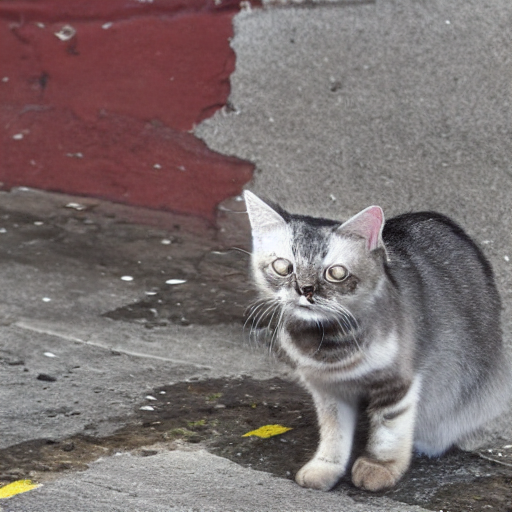

In [10]:
precision_scope = autocast if opt.precision=="autocast" else nullcontext
injected_features = load_target_features()
unconditional_prompt = ""
with torch.no_grad():
    with precision_scope("cuda"):
        with model.ema_scope():
            uc = None
            nc = None
            if exp_config.scale != 1.0:
                uc = model.get_learned_conditioning(batch_size * [unconditional_prompt])
                nc = model.get_learned_conditioning(batch_size * [negative_prompt])
            if not isinstance(prompts, list):
                prompts = list(prompts)
            c = model.get_learned_conditioning(prompts)
            shape = [opt.C, opt.H // opt.f, opt.W // opt.f]
            samples_ddim, _ = sampler.sample(S=ddim_steps,
                                                conditioning=c,
                                                negative_conditioning=nc,
                                                batch_size=len(prompts),
                                                shape=shape,
                                                verbose=False,
                                                unconditional_guidance_scale=exp_config.scale,
                                                unconditional_conditioning=uc,
                                                eta=opt.ddim_eta,
                                                x_T=start_code,
                                                img_callback=ddim_sampler_callback,
                                                injected_features=injected_features,
                                                negative_prompt_alpha=exp_config.negative_prompt_alpha,
                                                negative_prompt_schedule=exp_config.negative_prompt_schedule,
                                                )

            x_samples_ddim = model.decode_first_stage(samples_ddim)
            x_samples_ddim = torch.clamp((x_samples_ddim + 1.0) / 2.0, min=0.0, max=1.0)
            x_samples_ddim = x_samples_ddim.cpu().permute(0, 2, 3, 1).numpy()
            if opt.check_safety:
                x_samples_ddim = check_safety(x_samples_ddim)
            x_image_torch = torch.from_numpy(x_samples_ddim).permute(0, 3, 1, 2)

            sample_idx = 0
            for k, x_sample in enumerate(x_image_torch):
                x_sample = 255. * rearrange(x_sample.cpu().numpy(), 'c h w -> h w c')
                img = Image.fromarray(x_sample.astype(np.uint8))
                img.save(os.path.join(outpaths[k], f"{out_label}_sample_{sample_idx}.png"))
                sample_idx += 1

print(f"PnP results saved in: {'; '.join(outpaths)}")
# show the img
img = Image.open(os.path.join(outpaths[0], f"{out_label}_sample_0.png"))
img